In [1]:
import numpy as np
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import random
import copy
import ipython_bell

from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 56#46 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
def make_plot(image_g, image_r, image_i):
    #"""
    rgb = make_lupton_rgb(np.log10(image_g), np.log10(image_r), np.log10(image_i), Q=2., stretch=4.)
    plt.figure()
    plt.imshow(rgb)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.savefig('Image' + str(i) + '.png', bbox_inches='tight')
    plt.show(block=True)
    #plt.close()
    #"""

In [4]:
def simulation(redshifts, magnitude_lens, r_sersic, sigma, lens_ellip, i):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source1']
                            } 
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': sigma, 'center_x': 0, 'center_y': 0, 
                    'e1': lens_ellip[0], 'e2': lens_ellip[1]}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #lens light distribution
    m_lens_g, m_lens_r, m_lens_i = magnitude_lens['g'], magnitude_lens['r'], magnitude_lens['i']
    kwargs_lens_light_mag_g = [{'magnitude': m_lens_g, 'R_sersic': r_sersic['g'], 'n_sersic': 2, 
                                'e1': 0., 'e2': 0., 'center_x': 0, 'center_y': 0}]
    
    #First source light distributions & colors of the other bands for each source
    kwargs_source_mag_g = [{'magnitude': 80, 'R_sersic': 0.5, 'n_sersic': 1.3, 'e1': 0., 'e2': 0.,
                              'center_x': 0, 'center_y': 0}]
    #Adding color distribution to the bands (lens):
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'], kwargs_lens_light_mag_r[0]['R_sersic'] = m_lens_r, r_sersic['r']
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_r)
    kwargs_lens_light_mag_i[0]['magnitude'], kwargs_lens_light_mag_r[0]['R_sersic'] = m_lens_i, r_sersic['i']
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r, kwargs_source_mag_i= copy.deepcopy(kwargs_source_mag_g), copy.deepcopy(kwargs_source_mag_g)
        
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_g, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_r, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_mag_i, 
                                                    kwargs_source_mag=None, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    image_g = image_g[::-1]
    image_r = image_r[::-1]
    image_i = image_i[::-1] 
    
    return(image_g, image_r, image_i)
    

In [5]:
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
data_gal = pd.read_csv(path + 'tests/calibration/galaxies/galaxies_cal.csv')
print(len(data_gal))
data_gal

10


,COADD_OBJECT_ID,MAG_PSF_G,MAG_PSF_R,MAG_PSF_I,MAG_APER_8_G,MAG_APER_8_R,MAG_APER_8_I,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,DNF_ZMEAN_SOF,SOF_CM_G_1,SOF_CM_G_2
0,104597255,20.000189,19.656212,19.585812,19.454721,18.934473,18.641640,5.053434,4.923530,4.623868,0.113484,0.123539,0.404694
1,74197853,20.000381,19.485188,19.357426,18.509636,17.978928,17.763687,15.359547,14.689729,14.438297,0.057459,0.030343,-0.304541
2,108195159,20.000412,18.915199,18.653852,19.613064,18.477253,18.067923,5.440722,4.883713,4.390888,0.151424,0.018555,-0.081256
3,105134094,20.000147,18.894682,18.564068,19.607409,18.497381,18.088509,4.215121,3.701985,3.311348,0.159497,0.460280,-0.098820
4,97247806,19.999437,19.627411,19.599571,19.816130,19.161932,18.842983,4.373772,4.506986,4.296479,0.111708,-0.126554,0.591994
5,66646122,20.000784,19.367769,18.954859,19.562481,18.763348,18.369722,3.996571,3.704079,3.697211,0.160074,0.021403,0.008157
6,62465785,20.000414,19.871923,19.744852,19.613028,19.183395,19.026306,4.247505,4.344206,4.414184,0.055981,0.009715,0.360652
7,85958272,20.000954,19.286839,18.939394,19.955053,19.072386,18.679413,3.199608,3.141588,2.751997,0.219850,-0.038652,0.044538
8,100855766,20.000830,19.128592,18.877293,19.756779,18.826584,18.511383,3.383106,3.179099,3.174660,0.225554,0.000368,-0.045419
9,74378134,20.000364,19.224535,18.918804,19.308926,18.493809,18.148487,5.507727,5.136478,4.732590,0.136706,0.003919,-0.052152


In [6]:
def simulations_from_data(filename):
    x = np.zeros((1,3,numpix,numpix))
    data = data_gal = pd.read_csv(filename)
    for index, row in data.iterrows():
        
        coadd_id = int(row['COADD_OBJECT_ID'])
        z_lens = row['DNF_ZMEAN_SOF']
        z_source1 = random.uniform(z_lens + 0.3, z_lens + 0.4) # 0.35, 0.7
        redshifts = {'lens': z_lens, 'source1': z_source1}
        magnitude_lens = {'g': row['MAG_PSF_G'], 'r': row['MAG_PSF_R'], 'i': row['MAG_PSF_I']}
        dispersion = 200
        r_sersic = {'g': row['FLUX_RADIUS_G']*0.2637, 'r': row['FLUX_RADIUS_R']*0.2637, 'i': row['FLUX_RADIUS_I']*0.2637}
        
        angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
        e1, e2 = param.phi_q2_ellipticity(angle, ratio)
        lens_ellip = [e1, e2]
    
        image_g, image_r, image_i = simulation(redshifts, magnitude_lens, r_sersic, dispersion, lens_ellip, coadd_id)
        #make_plot(image_g, image_r, image_i)
        
        ele_sim = np.array([image_g, image_r , image_i])
        x = np.append(x, [ele_sim], axis = 0)
        
    x = np.delete(x, 0, axis = 0)
    return(x)


In [7]:
filename = path + 'tests/calibration/galaxies/galaxies_cal.csv'
galaxies_sim = simulations_from_data(filename)

filename = path + 'tests/calibration/stars/stars_cal.csv'
stars_sim = simulations_from_data(filename)

In [8]:
def cutouts(filename):
    x = np.zeros((1,3,114,114))
    files = os.listdir(filename)
    for file in files:
        if(file[-7:] != '_g.fits'): continue
        new_name = filename + file[:-7]
        with fits.open(new_name + '_g.fits') as hdul: img_g = hdul[0].data
        with fits.open(new_name + '_i.fits') as hdul: img_i = hdul[0].data
        with fits.open(new_name + '_r.fits') as hdul: img_r = hdul[0].data
        ele_sim = np.array([img_g, img_i , img_r])
        x = np.append(x, [ele_sim], axis = 0)
    x = np.delete(x, 0, axis = 0)
    return(x)

In [9]:
filename = path + 'tests/calibration/galaxies/galaxies_cutouts/'
galaxies_real = cutouts(filename)

filename = path + 'tests/calibration/stars/stars_cutouts/'
stars_real = cutouts(filename)

In [19]:
print(galaxies_sim.shape)
print(galaxies_sim[0].shape)
print(galaxies_sim[0][0].shape)

(10, 3, 56, 56)
(3, 56, 56)
(56, 56)


In [34]:
def make_plot_all(galaxies_sim, stars_sim, galaxies_real, stars_real):
    plt.figure(figsize=(15,10))
    for i in range(5):
        plt.subplot(2,5,i+1)
        rgb = make_lupton_rgb(galaxies_sim[i][0], galaxies_sim[i][1], galaxies_sim[i][2], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
  
        plt.subplot(2,5,i+1+5)
        rgb = make_lupton_rgb(galaxies_sim[i][0], galaxies_sim[i][1], galaxies_sim[i][2], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.xticks([], [])
        plt.yticks([], [])
    plt.show()

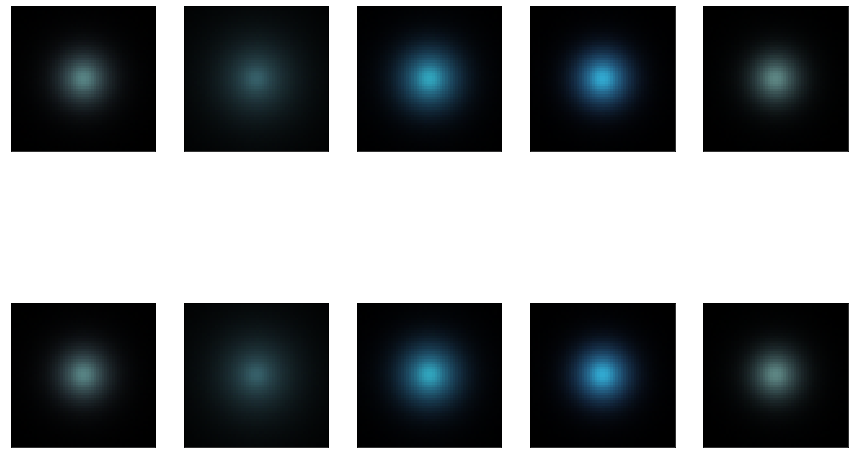

In [35]:
make_plot_all(galaxies_sim, stars_sim, galaxies_real, stars_real)